In [1]:
%matplotlib notebook

In [2]:
import pyspark
sc = pyspark.sql.SparkSession.Builder().getOrCreate()

In [3]:
import json
import numpy as np
import pandas as pd
import seaborn as sn

import matplotlib.pyplot as plt
from IPython.display import display, HTML
import math
import time
import matplotlib.animation as animation
from datetime import datetime, timedelta
import pyspark.sql.functions as F

from utils.emissions_normalizer import EmissionsNormalizer
from utils.knn_predictor import KnnPredictor
from utils.smoother import Smoother
from utils.random_predictor import RandomPredictor

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [4]:
ANTENNAS_POSITION = [(464259.981343845,6110331.85100085),(463512.015195402,6111004.324434620),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]
ANTENNAS_NAMES = ["RC1", "RC2", "D1", "D2"] 
X_0 = 462385.503783397
Y_0 = 6109042.35153865

for i in range(4):
    ANTENNAS_POSITION[i] = (ANTENNAS_POSITION[i][0]-X_0, ANTENNAS_POSITION[i][1]-Y_0)

GRID = Polygon(ANTENNAS_POSITION)

In [5]:
FEMALES = [11, 17, 20, 24, 26, 28, 30, 33, 34]
MALES = [10, 14, 21, 22, 23, 25, 27, 29, 31, 32]

In [6]:
birds_data = pd.read_parquet('../tmp/checkpoint-sd.parquet')

In [7]:
for i in range(4):
    col = 'recep_{}'.format(i)
    birds_data[col] = birds_data[col].astype(int)

In [8]:
birds_data['day'] = birds_data['timestamp'].str.split(' ').str[0]
birds_data['hour'] = birds_data['timestamp'].str.split(' ').str[1].str.split(':').str[0].astype(int)



In [9]:
birds_data.head()

,recep_0,recep_1,recep_2,recep_3,tag_id,timestamp,day,hour
0,44,50,0,0,24,2018-01-10 00:00:00,2018-01-10,0
1,53,53,0,0,20,2018-01-10 00:00:00,2018-01-10,0
2,0,47,0,0,27,2018-01-10 00:00:02,2018-01-10,0
3,37,0,0,94,33,2018-01-10 00:00:02,2018-01-10,0
4,0,30,0,0,32,2018-01-10 00:00:03,2018-01-10,0


In [10]:
from datetime import datetime

def get_seq_time(row):
    return (datetime.strptime(row['timestamp'], '%Y-%m-%d %H:%M:%S')-datetime.strptime(row['day'], '%Y-%m-%d')).total_seconds()

def get_hour_from_seq_time(seq_time):
    seconds = seq_time%60
    seq_time = (seq_time-seconds)/60
    minutes = seq_time%60
    seq_time = (seq_time-minutes)/60
    hour = seq_time
    return '{}:{}:{}'.format(
        str(int(hour)).rjust(2, '0'), 
        str(int(minutes)).rjust(2, '0'), 
        str(int(seconds)).rjust(2, '0')
    )


In [11]:
birds_data['seq_time'] = birds_data.apply(get_seq_time, axis=1)

<IPython.core.display.Javascript object>


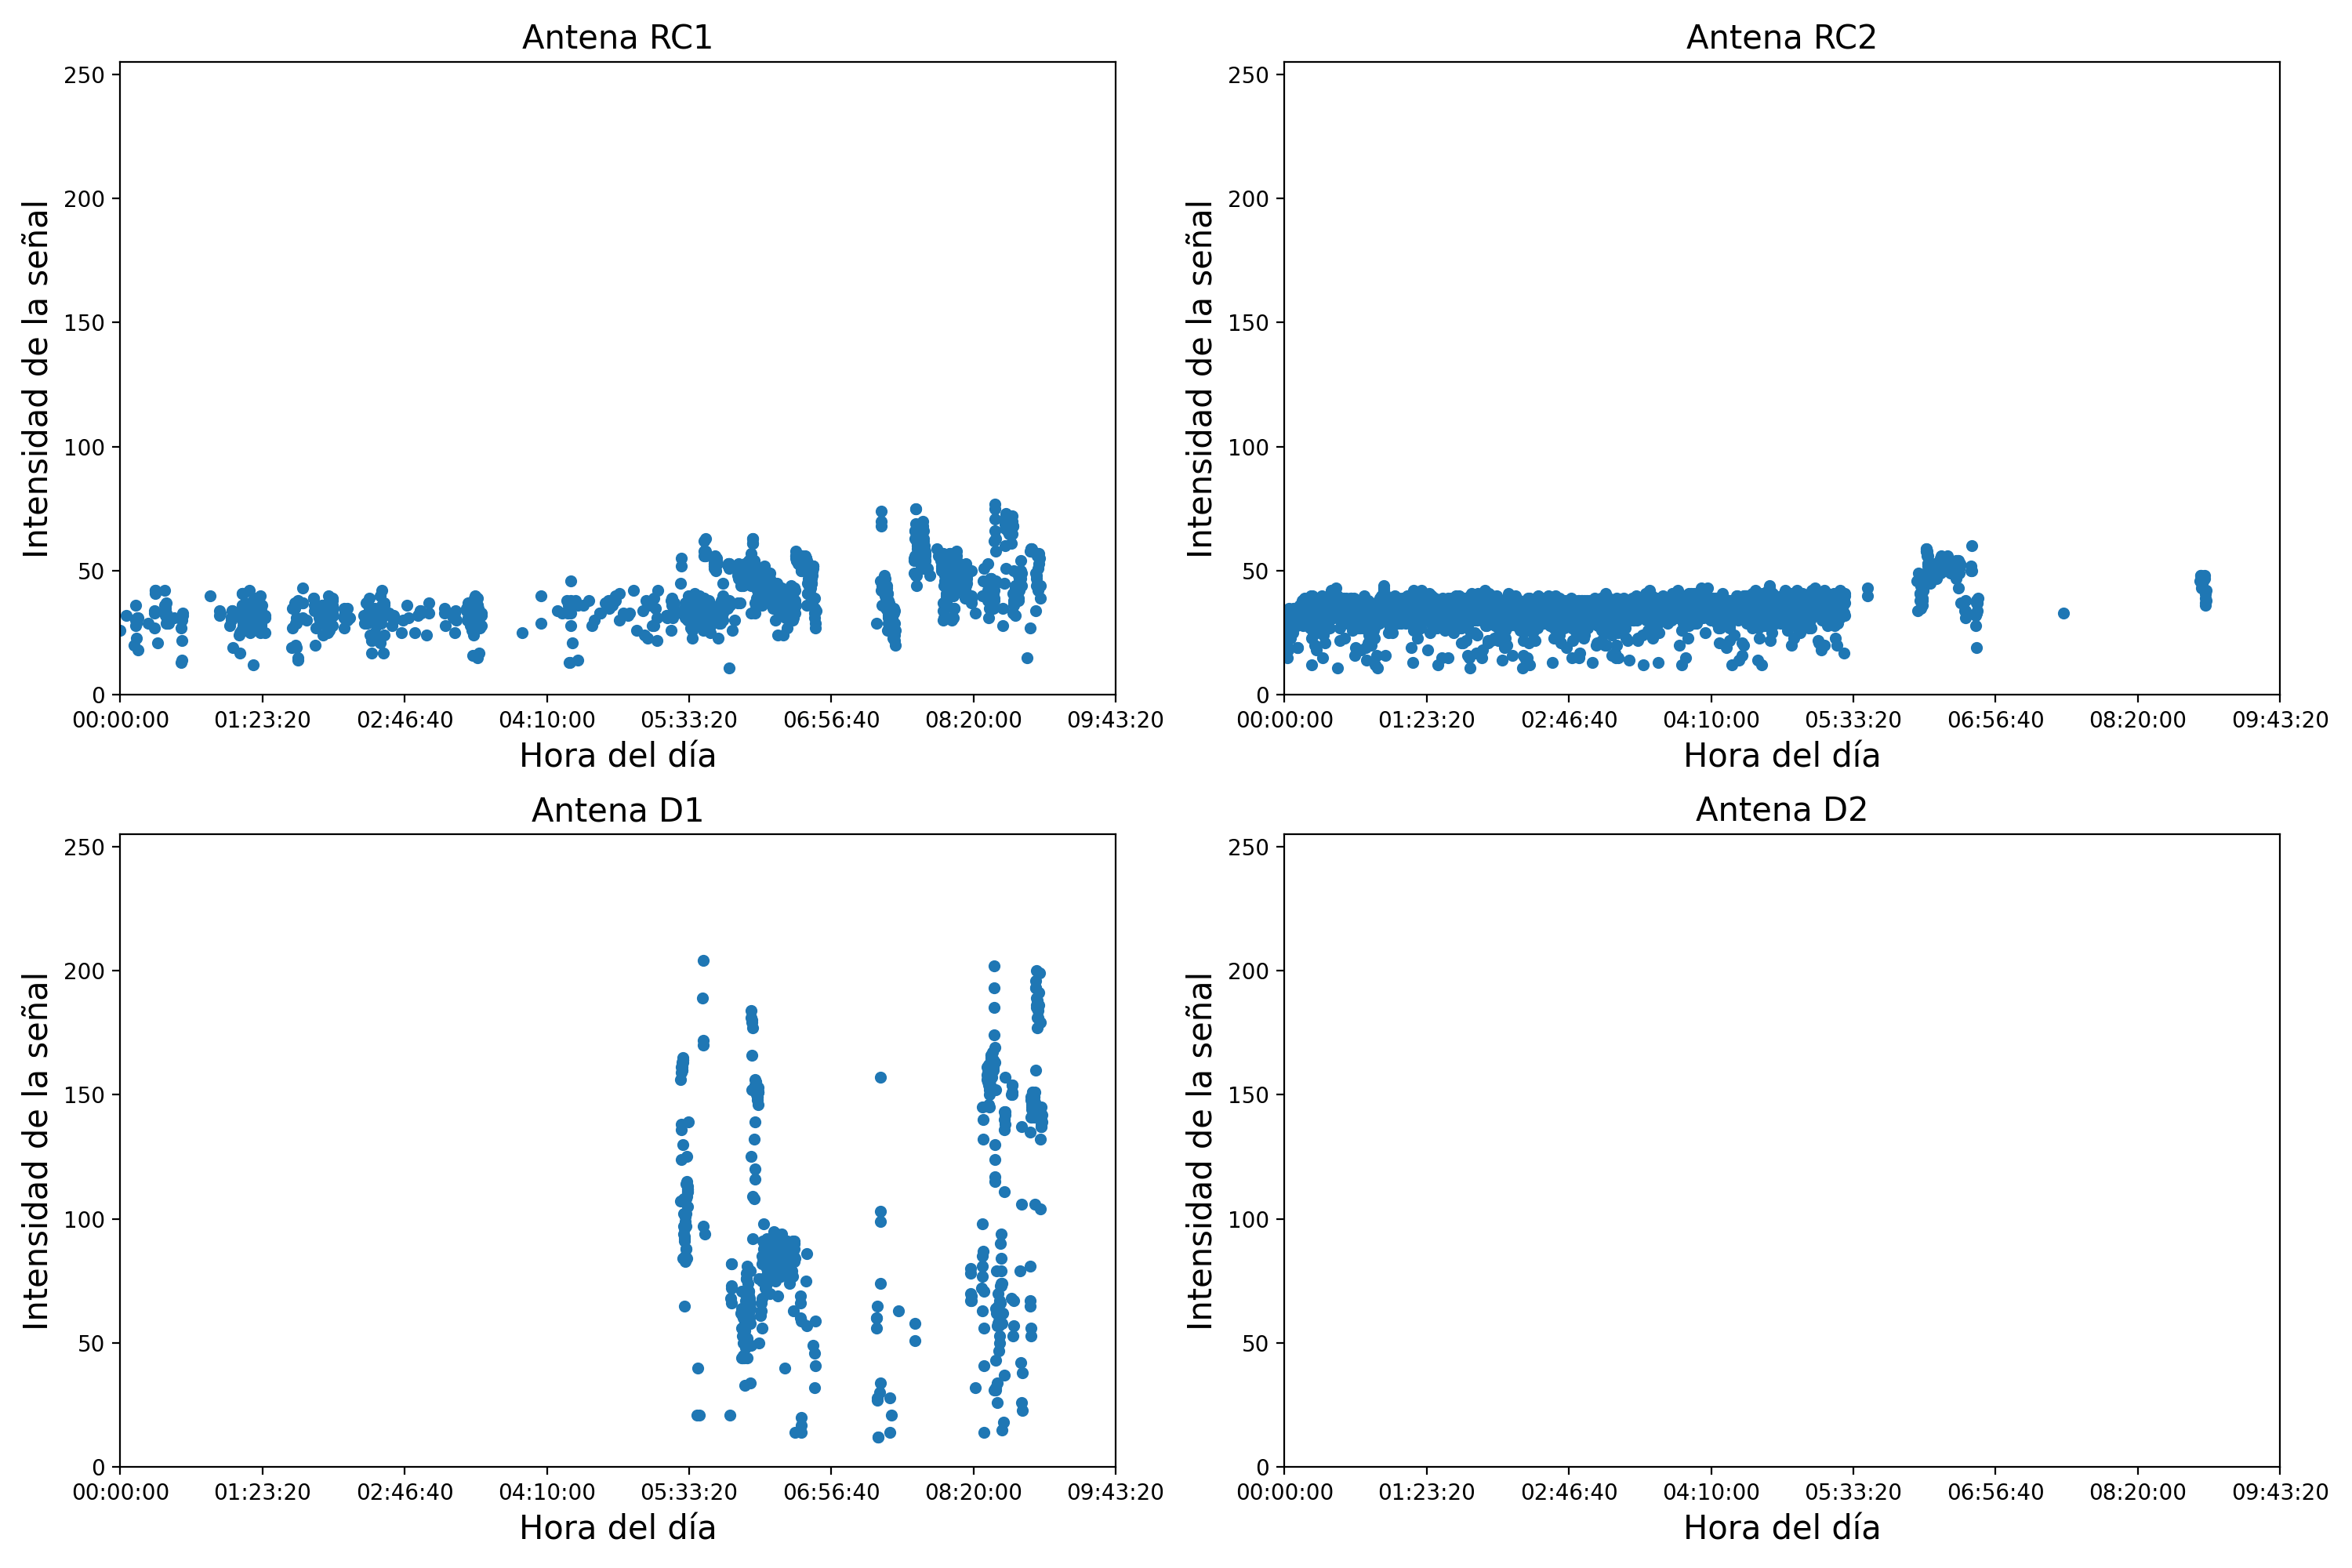

In [426]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2,2, figsize=(15,10))


DAY = '2018-01-12'
BIRD = 20

for i in range(2):
    for j in range(2):
        data = birds_data.query('day == "{}" and tag_id == {}'.format(DAY, BIRD))
        data = data.query('recep_{} > 0'.format(i*2+j))
        if len(data) == 0:
            data = pd.DataFrame({'seq_time': [-1000], 'recep_{}'.format(i*2+j): 0})
        data.plot(kind='scatter', x='seq_time', y='recep_{}'.format(i*2+j), xlim=(0,35000), ylim=(0,255), ax=axes[i,j])
        #data.plot.scatter(x='seq_time', y=f'recep_{i*2+j}', xlim=(0,35000), ylim=(0,255), ax=axes[i,j])

        axes[i,j].set_xticklabels([get_hour_from_seq_time(tick) for tick in axes[i,j].get_xticks().astype(int)])        
        axes[i,j].set_title(f'Antena {ANTENNAS_NAMES[i*2+j]}', fontsize=15)
        axes[i,j].set_ylabel('Intensidad de la señal',  fontsize=15)
        axes[i,j].set_xlabel('Hora del día', fontsize=15)
plt.tight_layout()
plt.savefig('Ejemplo-intensidades-20-2018_01_12.png')

<IPython.core.display.Javascript object>


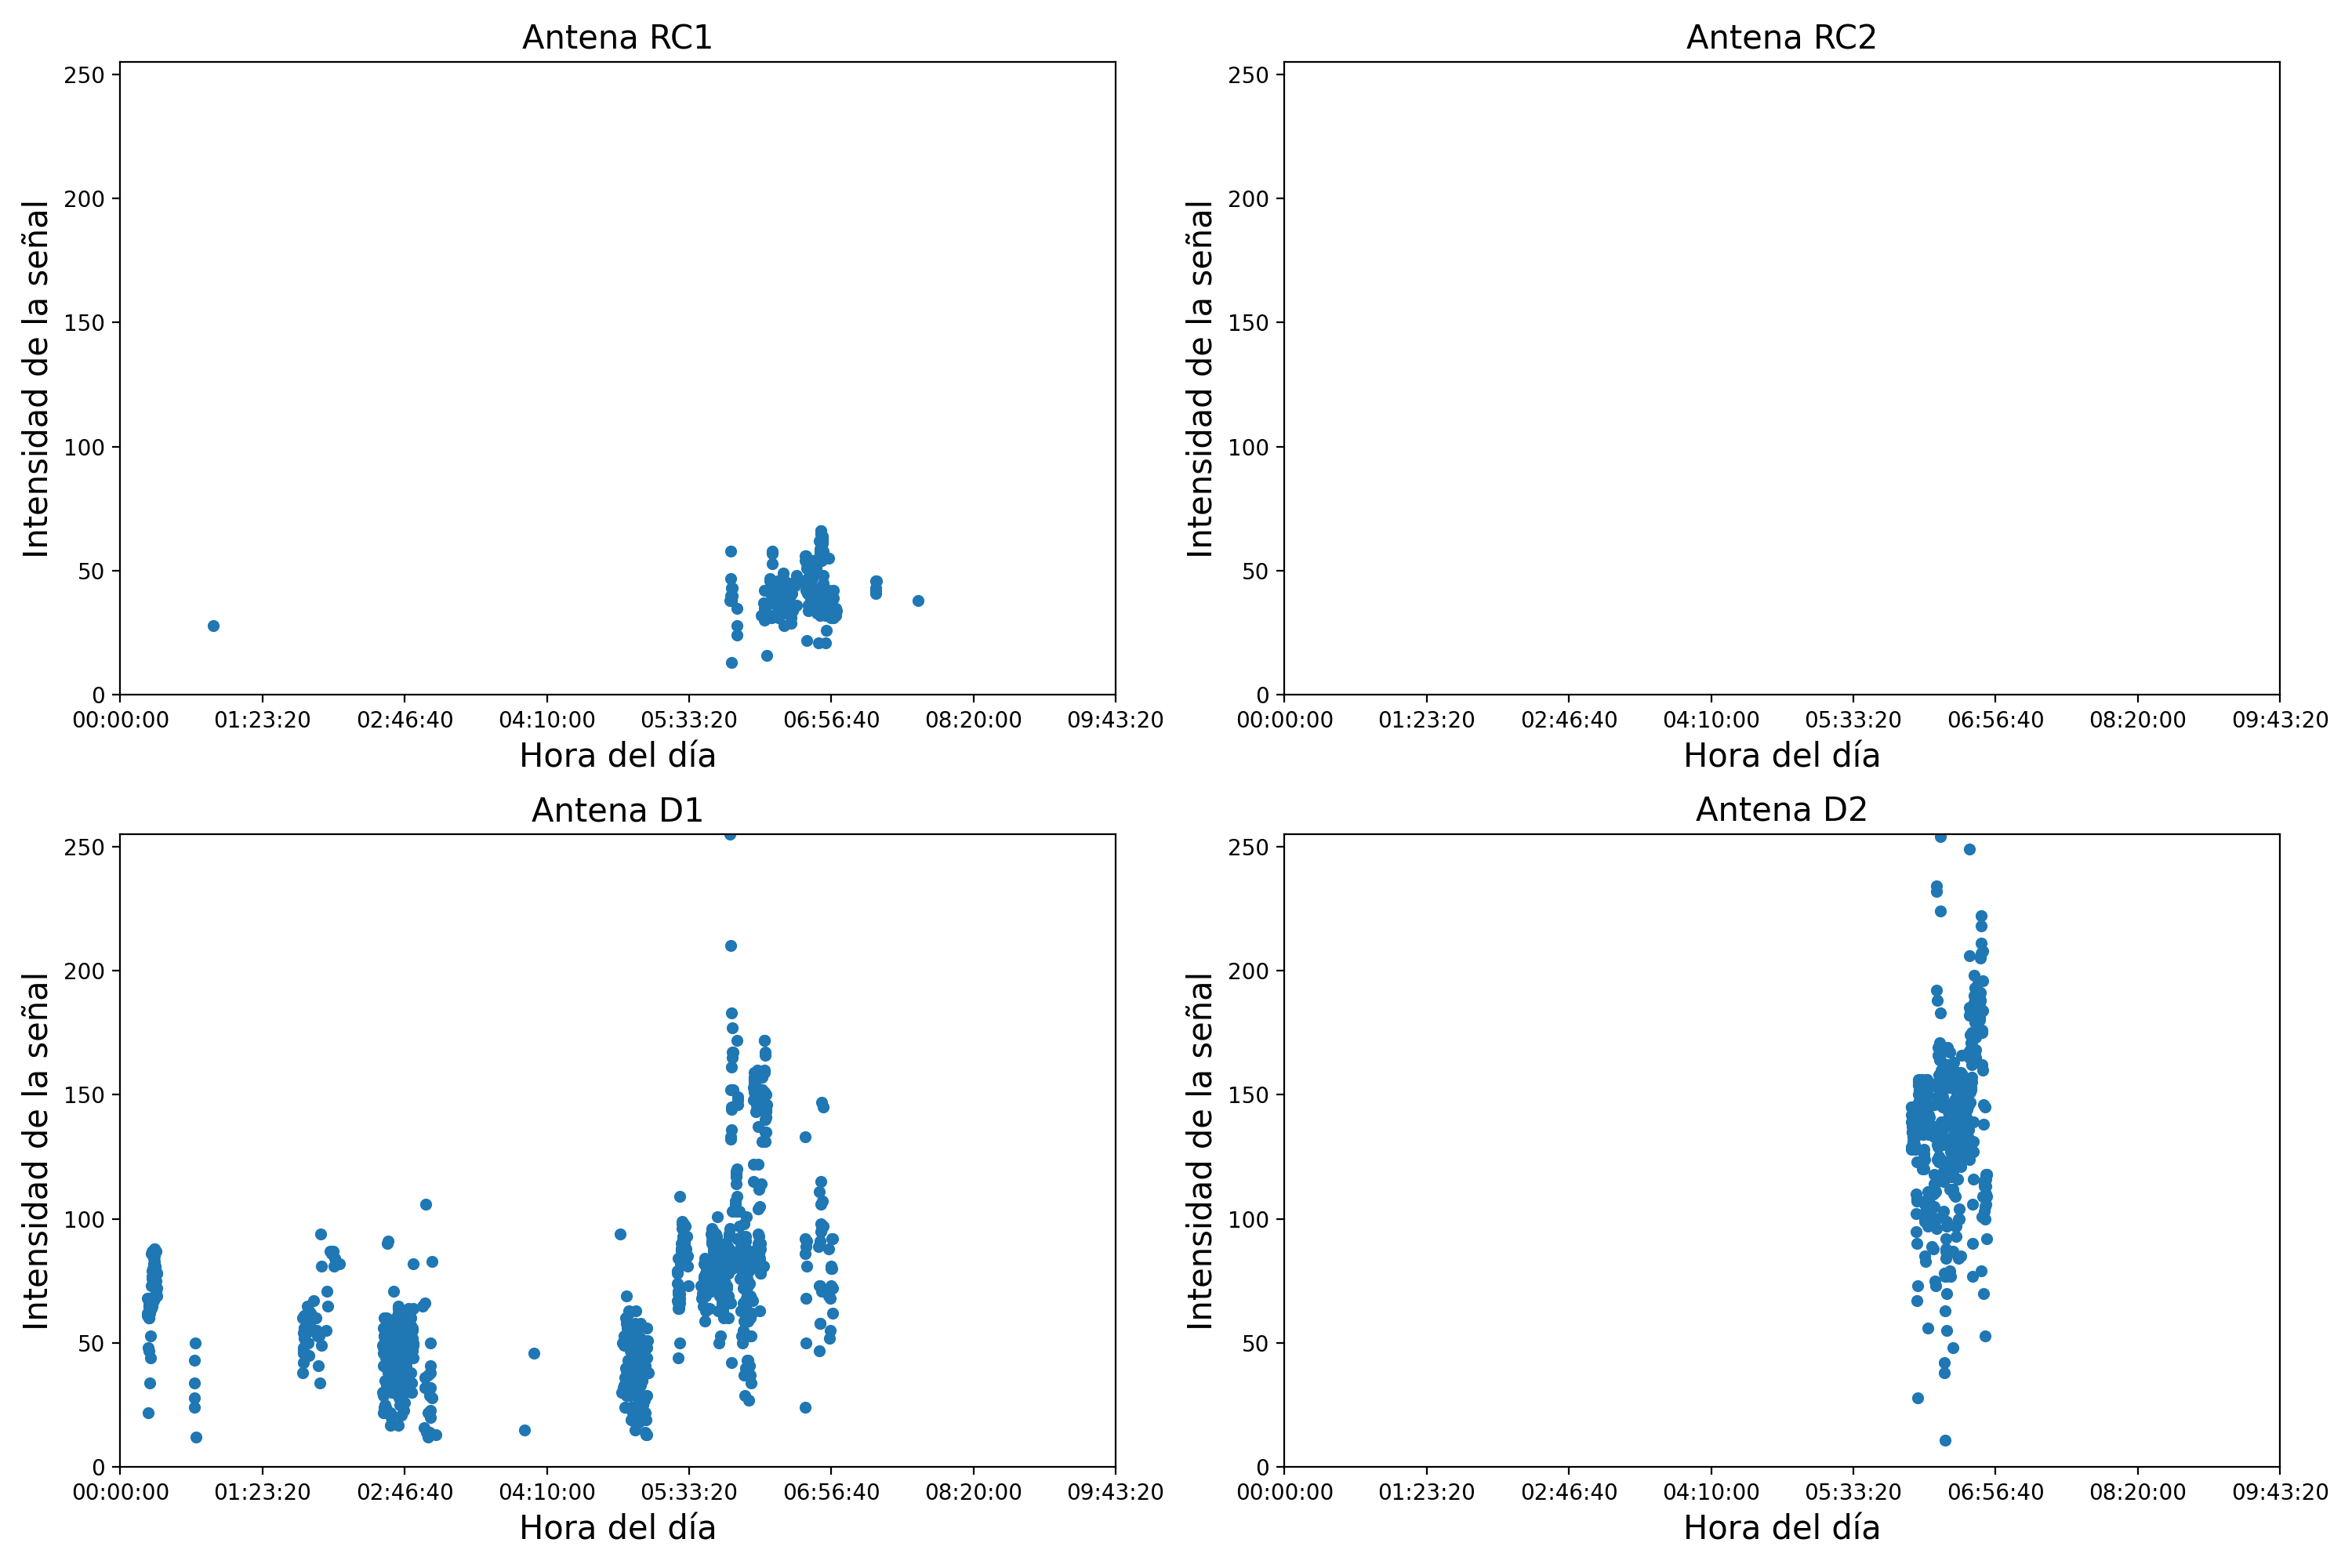

In [427]:

import matplotlib.pyplot as plt
fig, axes = plt.subplots(2,2, figsize=(15,10))


DAY = '2018-01-19'
BIRD = 27

for i in range(2):
    for j in range(2):
        data = birds_data.query('day == "{}" and tag_id == {}'.format(DAY, BIRD))
        data = data.query('recep_{} > 0'.format(i*2+j))
        if len(data) == 0:
            data = pd.DataFrame({'seq_time': [-1000], 'recep_{}'.format(i*2+j): 0})
        data.plot(kind='scatter', x='seq_time', y='recep_{}'.format(i*2+j), xlim=(0,35000), ylim=(0,255), ax=axes[i,j])
        #data.plot.scatter(x='seq_time', y=f'recep_{i*2+j}', xlim=(0,35000), ylim=(0,255), ax=axes[i,j])

        axes[i,j].set_xticklabels([get_hour_from_seq_time(tick) for tick in axes[i,j].get_xticks().astype(int)])        
        axes[i,j].set_title(f'Antena {ANTENNAS_NAMES[i*2+j]}', fontsize=15)
        axes[i,j].set_ylabel('Intensidad de la señal',  fontsize=15)
        axes[i,j].set_xlabel('Hora del día', fontsize=15)
plt.tight_layout()
plt.savefig('Ejemplo-intensidades-27-2018_01_19.png')

In [14]:
import ruptures as rpt

In [15]:
data_rpt = birds_data.query('day == "{}" and tag_id == {} and recep_0 > 0'.format(DAY, BIRD))['recep_0'].to_numpy()

In [296]:
def draw_detection(model, data, n=1, penalty=None,epsilon=None,draw=True):
    algo = model.fit(data)
    if n is not None:
        result = algo.predict(n_bkps=n)
    elif penalty is not None:
        result = algo.predict(pen=penalty)
    elif epsilon is not None:
        result = algo.predict(epsilon=epsilon)
    else:
        raise Exception()

    if draw:
        rpt.display(data, [], result)
        plt.show()
    return result


<IPython.core.display.Javascript object>


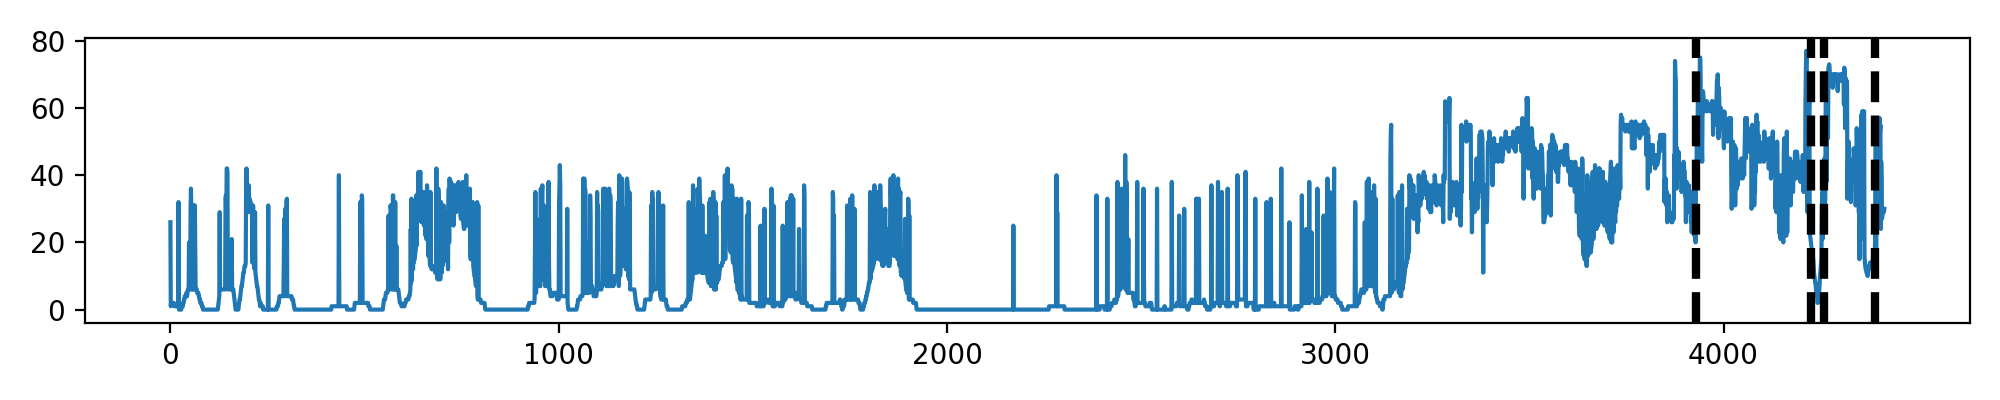

[3930, 4225, 4260, 4390, 4415]

In [374]:
data_test = birds_data.query('day == "{}" and tag_id == {}'.format(DAY, BIRD))['recep_0'].to_numpy()
data_test_c = data_test.copy()
for i in range(len(data_test)):
    if data_test[i] == 0:
        data_test[i] = np.mean(data_test_c[max(0,i-20):min(i+20,len(data_test))])
        
draw_detection(rpt.Window(model="l2", width=40), data_test, n=4)

<IPython.core.display.Javascript object>


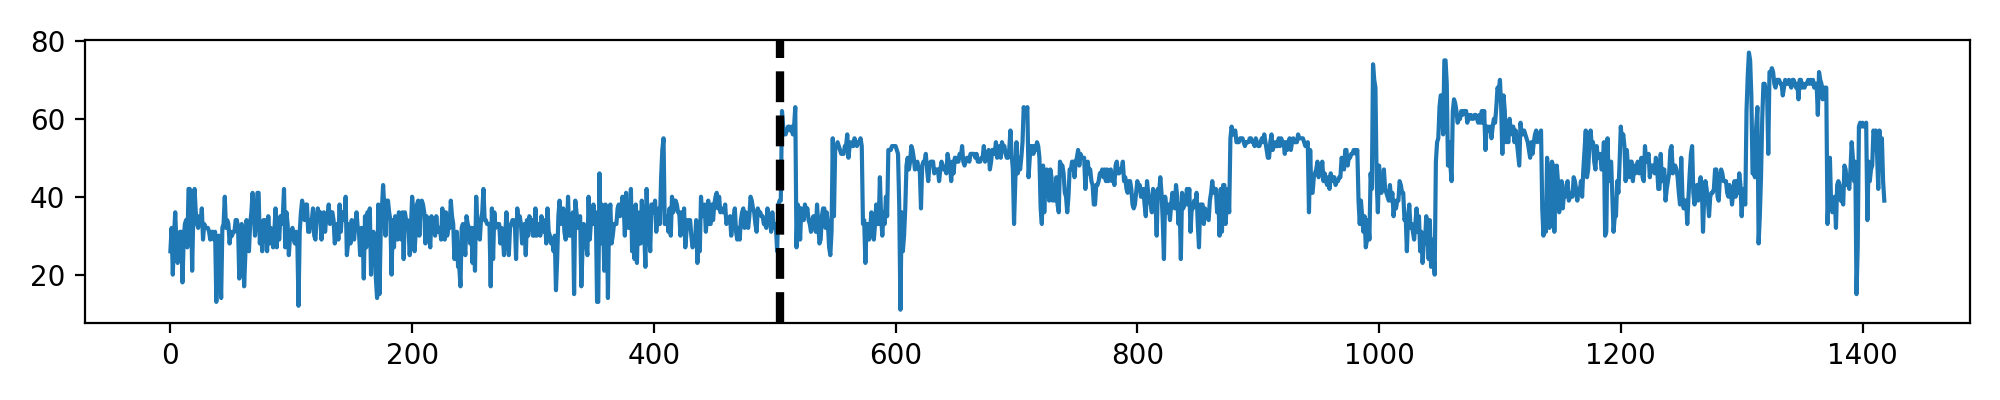

[505, 1419]

In [372]:
draw_detection(rpt.Binseg(model="l2"), data_rpt)

<IPython.core.display.Javascript object>


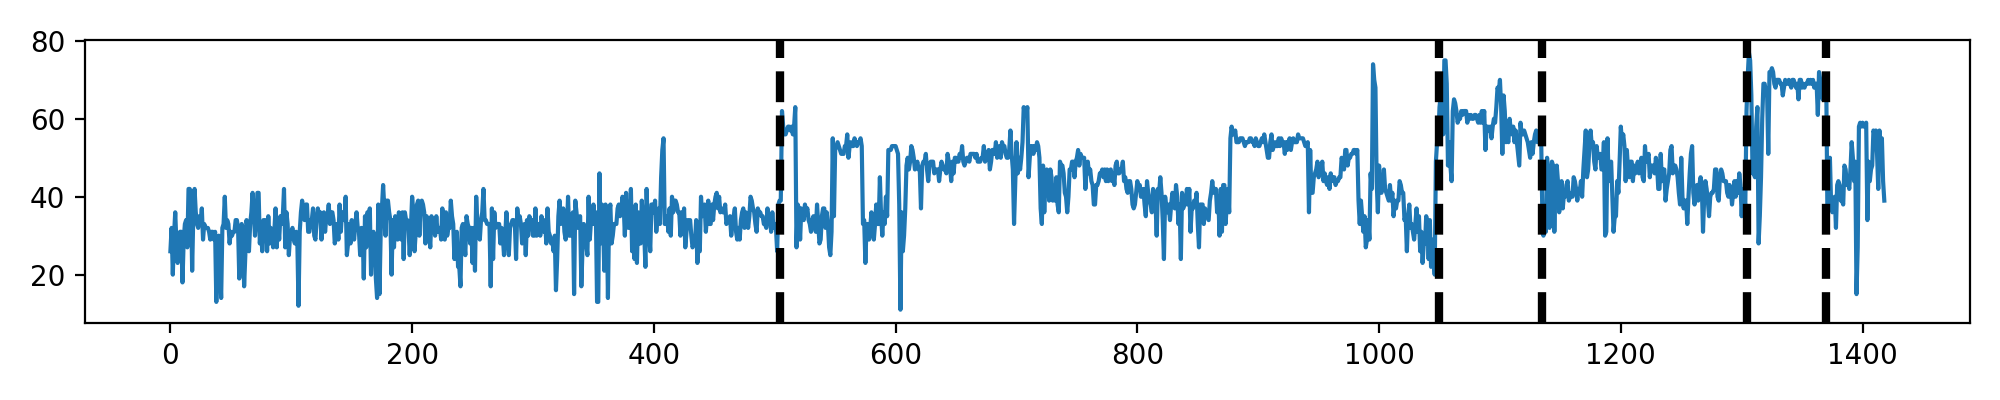

[505, 1050, 1135, 1305, 1370, 1419]

In [104]:
draw_detection(rpt.BottomUp(model="l2"), data_rpt)

<IPython.core.display.Javascript object>


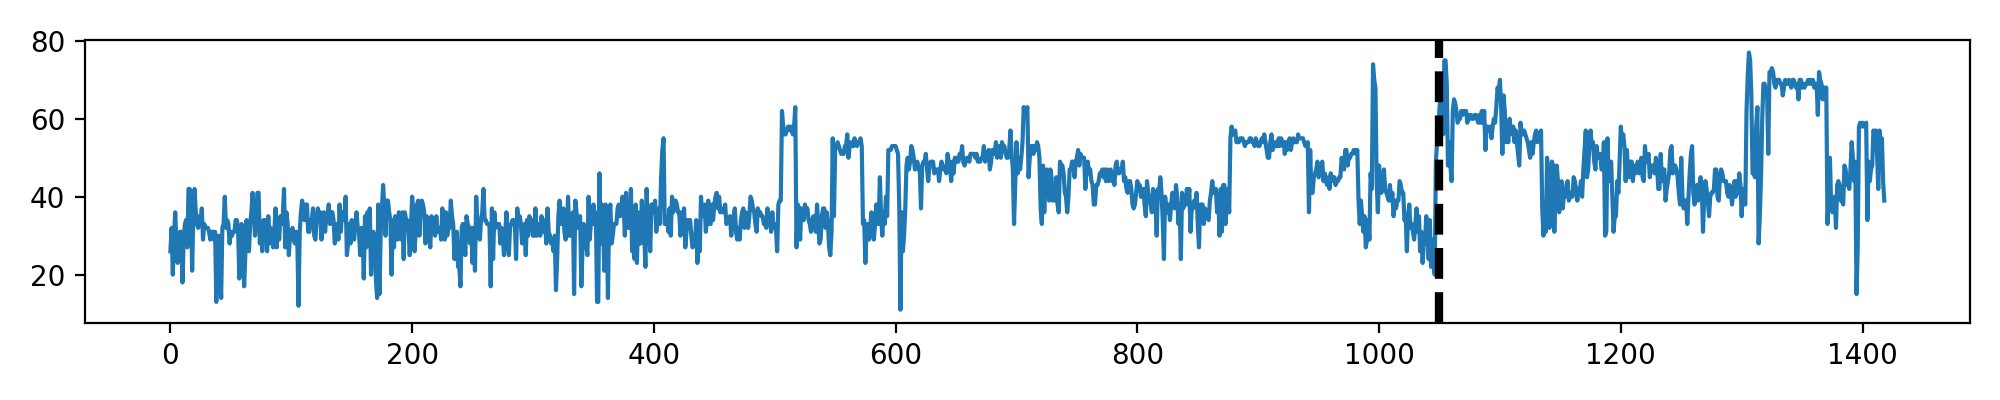

[1050, 1419]

In [139]:
draw_detection(rpt.Window(width=40, model="l2"), data_rpt)

#### Graficar de forma mas linda

In [182]:
DAY = '2018-01-25'
BIRD = 20

In [354]:
sample_data = birds_data.query('day == "{}" and tag_id == {} and recep_0 > 0'.format(DAY, BIRD))
sample_sign = sample_data['recep_0'].to_numpy()
results = draw_detection(rpt.Window(width=40, model="l2"), sample_sign, n=4,draw=False)
#epsilon=len(sample_sign)*np.std(sample_sign)**2
#penalty = 2*np.log(len(sample_sign))*np.std(sample_sign[50:100])**2
#results = draw_detection(rpt.Window(width=40, model="l2"), sample_sign, n=None,penalty=penalty,draw=True)


### 
voy a ser mas restrictivo y pedir uno o pocos puntos de deteccion. de esta forma, vamos a tener los puntos donde el cambio sea mas pronunciado. Si de esta forma, hay muchos casos donde salen antes de las 4am, siendo menos restrictivos eso va a pasar mas

<IPython.core.display.Javascript object>


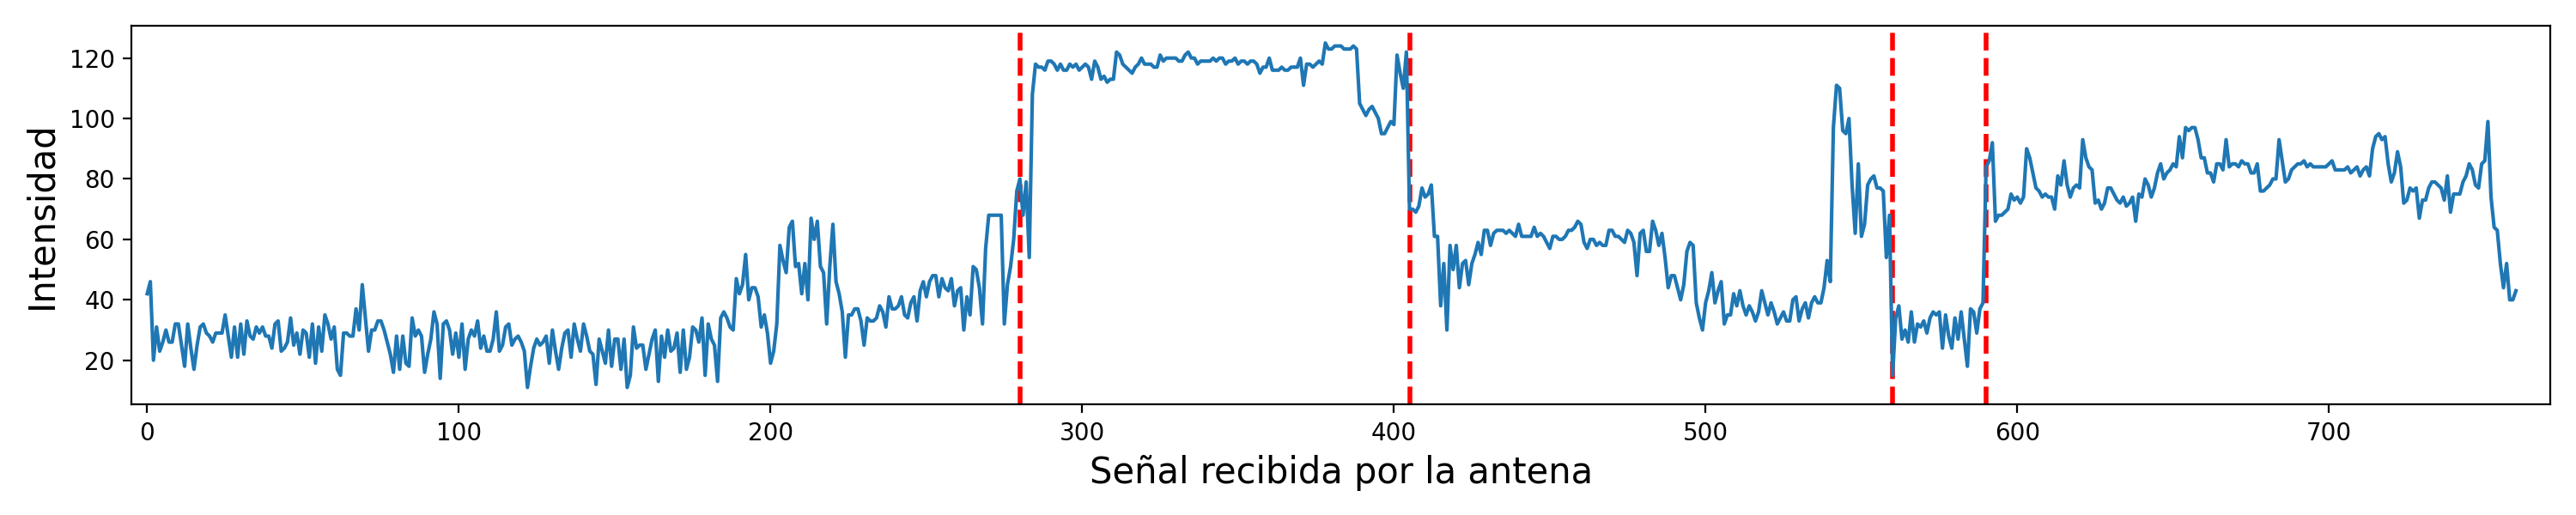

In [366]:
fig, ax = plt.subplots(figsize=(15,3))
sn.lineplot(x='x' ,y='val', data=pd.DataFrame({'x': np.arange(len(sample_data)), 'val': sample_sign}),zorder=3, ax=ax)
for i in range(len(results)-1):
    ax.axvline(results[i], ls='--', color='red', lw=2, zorder=1)
ax.set_ylabel('Intensidad', fontsize=15)
ax.set_xlim((-5,len(sample_data)+10))
#ax.set_xlabel('Hora del día')
#ax.set_xticklabels([sample_data.iloc[tick]['timestamp'].replace(f'{DAY} ', '') if 0<=tick<=len(sample_data) else '' for tick in ax.get_xticks().astype(int)])        

#ax.set_xticklabels([ '' for tick in ax.get_xticks().astype(int)])        
#ax.set_xticks([])
ax.set_xlabel('Señal recibida por la antena', fontsize=15)

plt.tight_layout()
plt.savefig('EjemploPCD-RC1-20-2018_01_25.png')



#### Funciones de deteccion de la hora

In [23]:
def get_exit_roost_time_new(bird_data):
    res = {}
    for i in range(4):
        res['antenna_{}'.format(i)] = get_exit_roost_time_by_antenna(bird_data, i)
    return res

def get_exit_roost_time_by_antenna(bird_data, antenna):
    ### usando solo emisiones >0
    
    try:
        data = bird_data.query('recep_{} > 0'.format(antenna))
        if len(data) < 10:
            return 'undefined'
        data_rpt = data['recep_{}'.format(antenna)].to_numpy()


        model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
        algo = rpt.Binseg(model=model).fit(data_rpt)
        result = algo.predict(n_bkps=1)
        exit_roost_index = result[0]
    except Exception as e:
        print(e)
        return 'undefined'
    res = data.iloc[exit_roost_index]['timestamp']
    if data.iloc[exit_roost_index]['hour'] <= 3:
        return get_exit_roost_time_by_antenna(bird_data.query('timestamp > "{}"'.format(res)), antenna)
    return res

In [111]:
def get_exit_roost_time(bird_data):

    ### usando solo emisiones >0
    res = {}
    for i in range(4):
        try:
            data = bird_data.query('recep_{} > 0'.format(i))
            if len(data) < 10:
                res['antenna_{}'.format(i)] = 'undefined'
                continue
            data_rpt = data['recep_{}'.format(i)].to_numpy()
            

            model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
            
            algo = rpt.Window(width=40,model=model).fit(data_rpt)
            result = algo.predict(n_bkps=1)

            if len(data) > 200:
                algo = rpt.Window(width=40,model=model).fit(data_rpt)
            else:
                algo = rpt.Binseg(model=model).fit(data_rpt)
            result = algo.predict(n_bkps=1)
            print(f'day {bird_data.iloc[0]["day"]} - bird {bird_data.iloc[0]["tag_id"]} - result {result} - data {len(data)}')

            exit_roost_index = result[0]
        except Exception as e:
            print(e)
            res['antenna_{}'.format(i)] = 'undefined'
            continue
        res['antenna_{}'.format(i)] = data.iloc[exit_roost_index]['timestamp']
    return res


def get_exit_roost_time_v2(bird_data):
    ### usando emisiones >= 0
    res = {}
    for i in range(4):
        try:

            seq_time_list = bird_data['seq_time'].to_list()
            recep_list = bird_data['recep_{}'.format(i)].to_list()

            data_rpt = []
            seq_time_index = 0

            for sec in range(0, 32400):
                if seq_time_index == len(seq_time_list):
                    data_rpt.append(0)
                    continue
                if abs(seq_time_list[seq_time_index] - sec) < 5:
                    data_rpt.append(recep_list[seq_time_index])
                    seq_time_index += 1
                else:
                    data_rpt.append(0)
                    
            data_rpt = np.array(data_rpt)

            model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
            algo = rpt.Binseg(model=model).fit(data_rpt)
            result = algo.predict(n_bkps=1)
            exit_roost_index = result[0]
        except Exception as e:
            print(e)
            res['antenna_{}'.format(i)] = 'undefined'
            continue
        res['antenna_{}'.format(i)] = get_hour_from_seq_time(exit_roost_index)
    return res

In [113]:
birds_exit_time = birds_data.groupby(['day', 'tag_id']).apply(get_exit_roost_time)

day 2018-01-10 - bird 10 - result [25, 29] - data 29
day 2018-01-10 - bird 10 - result [75, 101] - data 101
day 2018-01-10 - bird 10 - result [15, 41] - data 41
day 2018-01-10 - bird 10 - result [25, 30] - data 30
day 2018-01-10 - bird 11 - result [20, 28] - data 28
day 2018-01-10 - bird 11 - result [50, 63] - data 63
day 2018-01-10 - bird 11 - result [10, 19] - data 19
day 2018-01-10 - bird 11 - result [5, 33] - data 33
day 2018-01-10 - bird 14 - result [455, 624] - data 624
day 2018-01-10 - bird 20 - result [1350, 1546] - data 1546
day 2018-01-10 - bird 20 - result [1450, 1554] - data 1554
day 2018-01-10 - bird 20 - result [1015, 1141] - data 1141
day 2018-01-10 - bird 20 - result [940, 1272] - data 1272
day 2018-01-10 - bird 21 - result [630, 693] - data 693
day 2018-01-10 - bird 21 - result [30, 46] - data 46
day 2018-01-10 - bird 21 - result [1745, 1792] - data 1792
day 2018-01-10 - bird 21 - result [150, 196] - data 196
day 2018-01-10 - bird 22 - result [165, 403] - data 403
day 

day 2018-01-13 - bird 20 - result [2875, 2932] - data 2932
day 2018-01-13 - bird 21 - result [2225, 2526] - data 2526
day 2018-01-13 - bird 21 - result [25, 44] - data 44
day 2018-01-13 - bird 21 - result [2520, 2937] - data 2937
day 2018-01-13 - bird 22 - result [25, 661] - data 661
day 2018-01-13 - bird 22 - result [20, 46] - data 46
day 2018-01-13 - bird 23 - result [15, 22] - data 22
day 2018-01-13 - bird 23 - result [35, 88] - data 88
day 2018-01-13 - bird 24 - result [600, 770] - data 770
day 2018-01-13 - bird 24 - result [4070, 4195] - data 4195
day 2018-01-13 - bird 24 - result [55, 109] - data 109
day 2018-01-13 - bird 26 - result [20, 23] - data 23
day 2018-01-13 - bird 27 - result [245, 477] - data 477
day 2018-01-13 - bird 27 - result [2685, 2720] - data 2720
day 2018-01-13 - bird 27 - result [2800, 2996] - data 2996
day 2018-01-13 - bird 28 - result [50, 113] - data 113
day 2018-01-13 - bird 28 - result [20, 35] - data 35
day 2018-01-13 - bird 28 - result [75, 88] - data 8

day 2018-01-17 - bird 27 - result [40, 206] - data 206
day 2018-01-17 - bird 28 - result [3140, 3205] - data 3205
day 2018-01-17 - bird 28 - result [5, 12] - data 12
day 2018-01-17 - bird 29 - result [5, 12] - data 12
day 2018-01-17 - bird 29 - result [5, 10] - data 10
day 2018-01-17 - bird 30 - result [105, 134] - data 134
day 2018-01-17 - bird 30 - result [60, 75] - data 75
day 2018-01-17 - bird 30 - result [10, 13] - data 13
day 2018-01-17 - bird 31 - result [75, 113] - data 113
day 2018-01-17 - bird 31 - result [10, 28] - data 28
day 2018-01-17 - bird 32 - result [240, 271] - data 271
day 2018-01-17 - bird 32 - result [10, 39] - data 39
day 2018-01-17 - bird 32 - result [135, 332] - data 332
day 2018-01-17 - bird 33 - result [275, 307] - data 307
day 2018-01-17 - bird 33 - result [30, 84] - data 84
day 2018-01-17 - bird 33 - result [205, 340] - data 340
day 2018-01-17 - bird 34 - result [5, 14] - data 14
day 2018-01-18 - bird 14 - result [4420, 4470] - data 4470
day 2018-01-18 - bi

day 2018-01-21 - bird 17 - result [380, 450] - data 450
day 2018-01-21 - bird 17 - result [3495, 3601] - data 3601
day 2018-01-21 - bird 20 - result [1190, 1423] - data 1423
day 2018-01-21 - bird 20 - result [2960, 3176] - data 3176
day 2018-01-21 - bird 20 - result [2145, 2169] - data 2169
day 2018-01-21 - bird 21 - result [25, 152] - data 152
day 2018-01-21 - bird 21 - result [3145, 3194] - data 3194
day 2018-01-21 - bird 21 - result [20, 310] - data 310
day 2018-01-21 - bird 22 - result [165, 216] - data 216
day 2018-01-21 - bird 24 - result [3695, 3980] - data 3980
day 2018-01-21 - bird 24 - result [480, 503] - data 503
day 2018-01-21 - bird 26 - result [10, 22] - data 22
day 2018-01-21 - bird 27 - result [660, 694] - data 694
day 2018-01-21 - bird 27 - result [2905, 3209] - data 3209
day 2018-01-21 - bird 27 - result [30, 264] - data 264
day 2018-01-21 - bird 29 - result [70, 146] - data 146
day 2018-01-21 - bird 29 - result [50, 72] - data 72
day 2018-01-21 - bird 32 - result [28

day 2018-01-25 - bird 32 - result [20, 688] - data 688
day 2018-01-25 - bird 32 - result [5, 11] - data 11
day 2018-01-25 - bird 33 - result [440, 472] - data 472
day 2018-01-25 - bird 33 - result [45, 445] - data 445
day 2018-01-25 - bird 34 - result [20, 110] - data 110
day 2018-01-25 - bird 34 - result [440, 583] - data 583


In [115]:
birds_exit_time_pd = pd.DataFrame(birds_exit_time.apply(lambda x: min(x.values())))

In [116]:
birds_exit_time_pd.columns = ['0']

In [117]:
birds_exit_time_pd.head()

0
day        tag_id                     
2018-01-10 10      2018-01-10 06:01:51
           11      2018-01-10 05:48:05
           14      2018-01-10 08:18:07
           15                undefined
           16                undefined

In [118]:
def get_secondos_of_day(hour):
    if isinstance(hour,float) and np.isnan(hour):
        return None
    return (datetime.strptime(hour, '%H:%M:%S')-datetime.strptime('00:00:00', '%H:%M:%S')).total_seconds()



In [439]:
sn.set(color_codes=True)


<IPython.core.display.Javascript object>


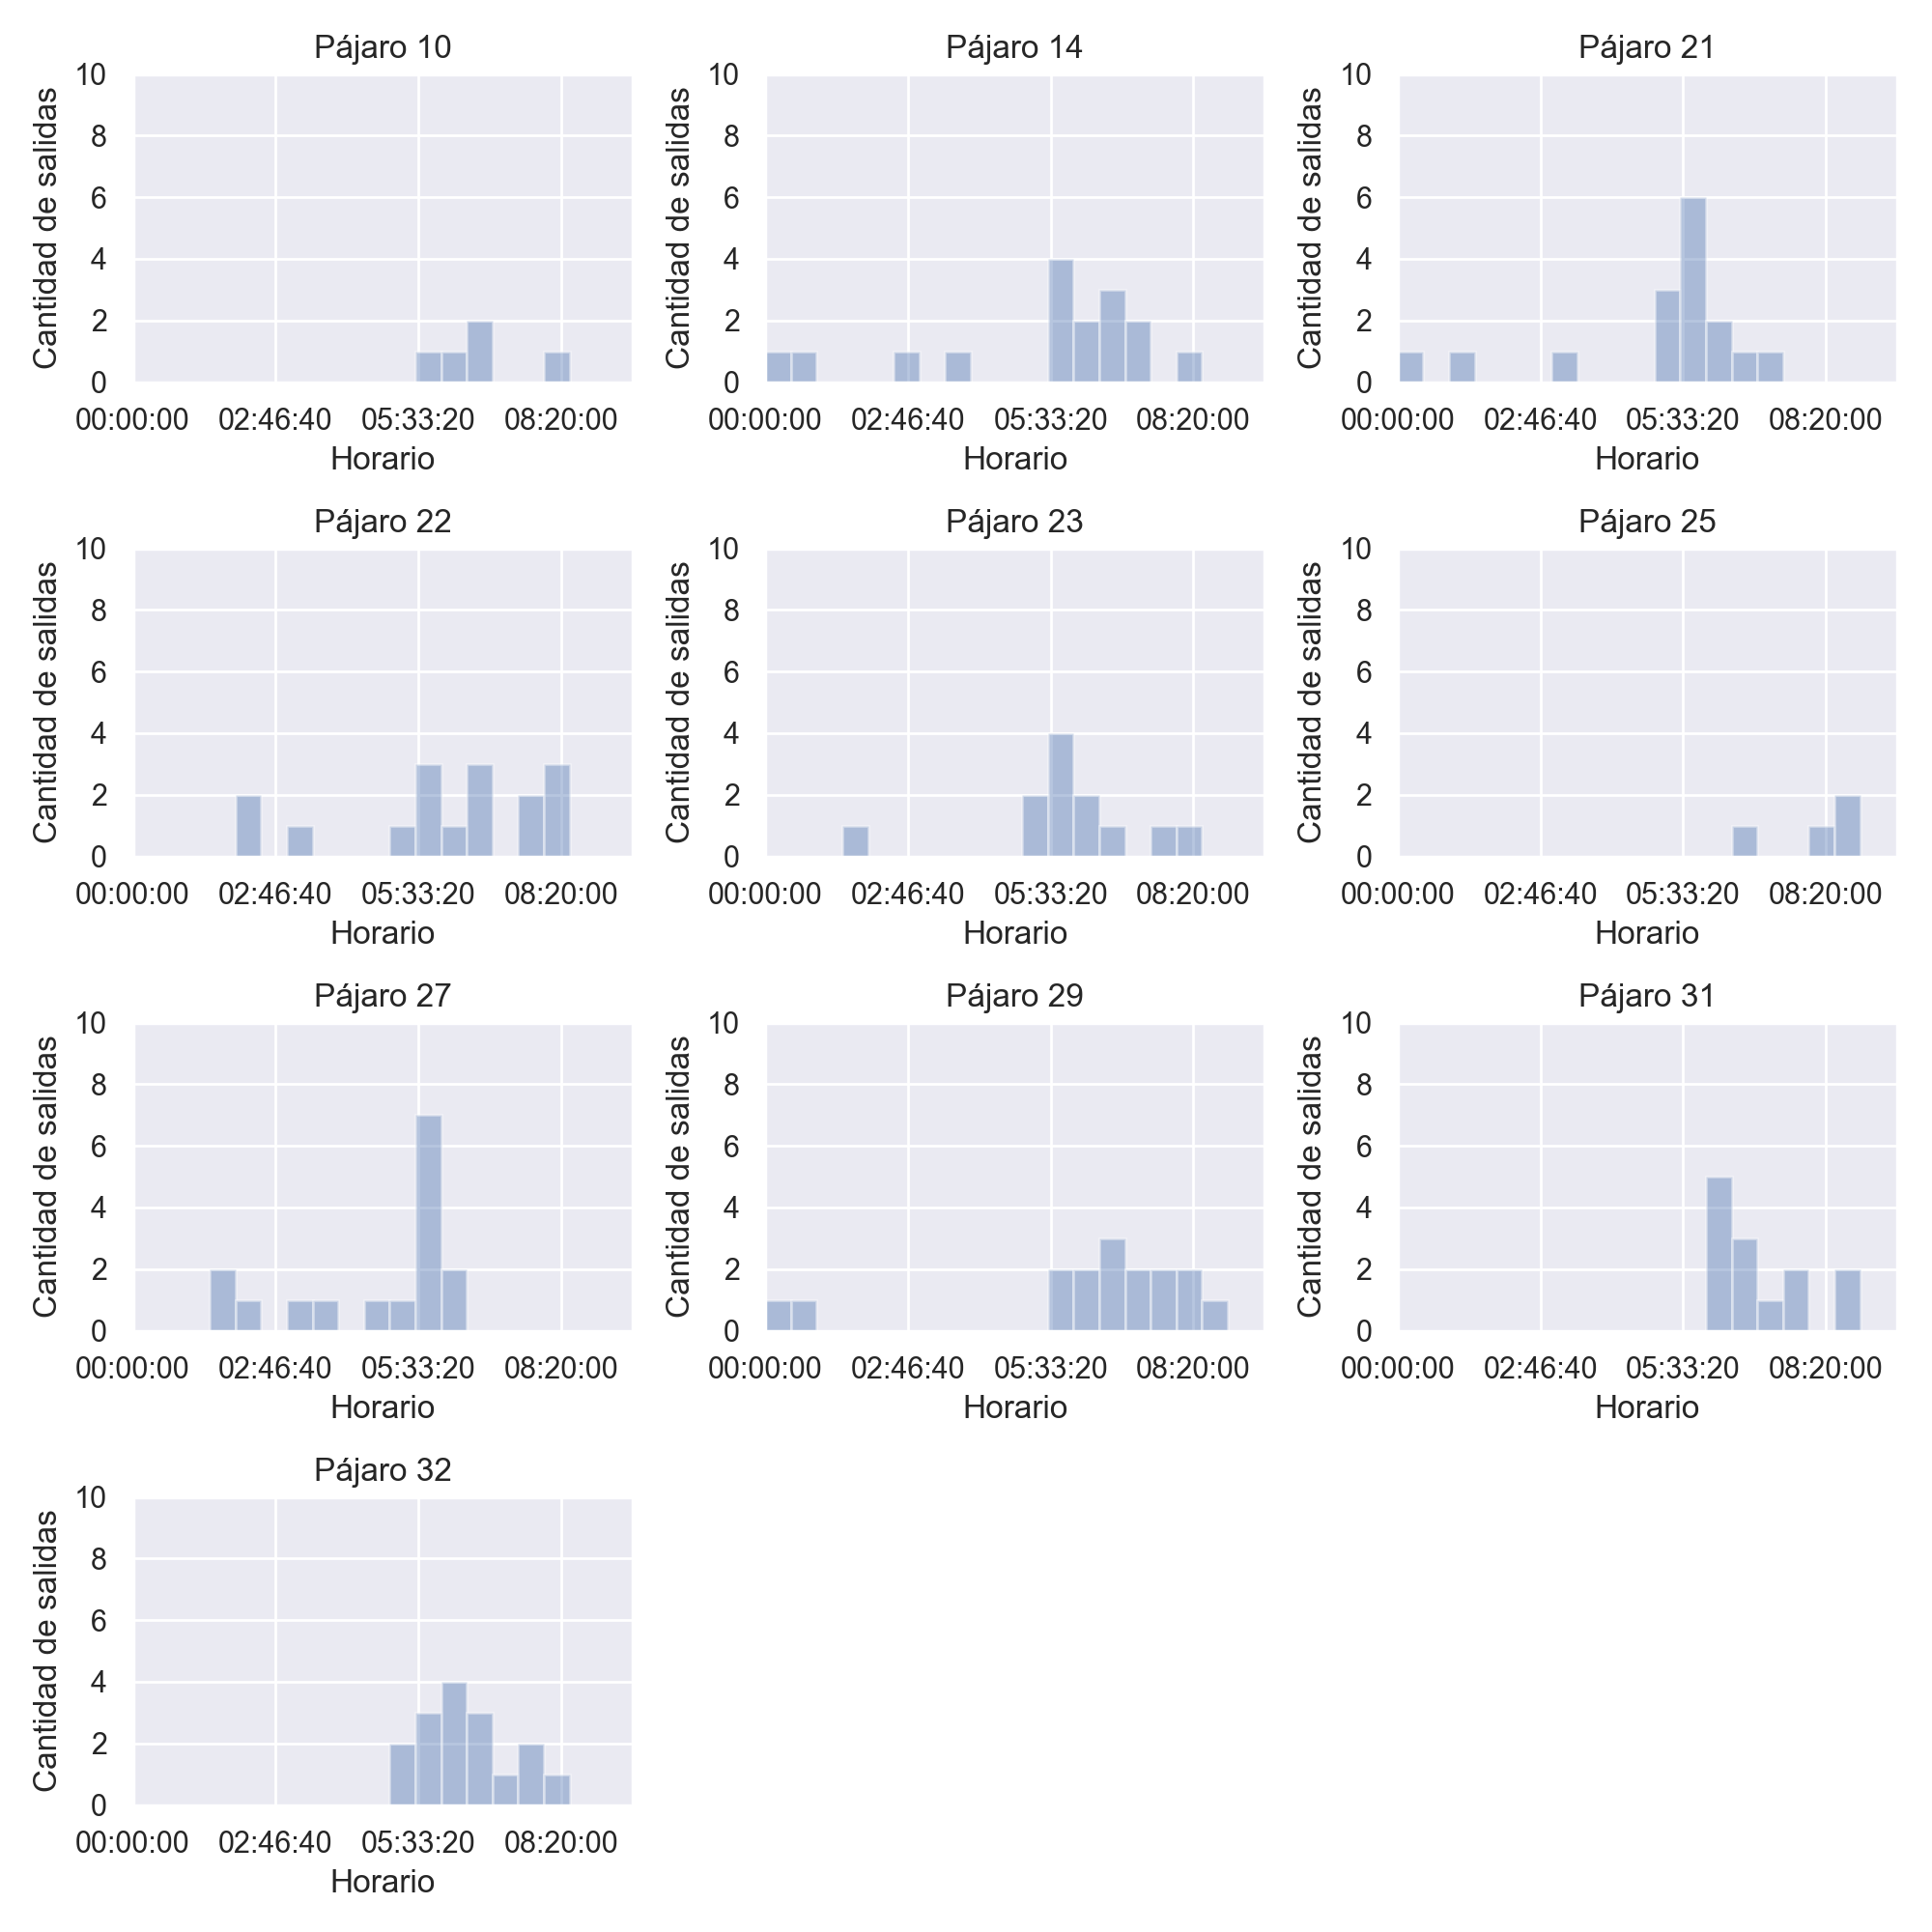

In [445]:
fig, axs = plt.subplots(4,3, figsize=(10,10))
#fig.suptitle('Males', fontsize=32)

fig.tight_layout()
i=0
for male in MALES:
    
    male_times_pd = pd.DataFrame(
        birds_exit_time_pd.reset_index().query('tag_id == {}'.format(male))["0"].str.split(' ').str[1].apply(get_secondos_of_day)
        #birds_exit_time_pd.reset_index().query('tag_id == {}'.format(male))["0"].apply(get_secondos_of_day)
    ).reset_index(drop=True)

    male_times_pd.columns = ['hour']
    male_times_pd['one'] = 1
    
    if len(male_times_pd[male_times_pd.hour.notna()]) == 0:
        print('No data for bird {}'.format(male))
        continue

    bins = [t*60*30 for t in range(19)]
    ax = axs.flatten()[i]
    #male_times_pd[male_times_pd.hour.notna()].hour.plot.hist(xlim=(0,35000), ylim=(0,10), title='Bird {}'.format(male), bins=bins, ax=ax)
    sn.distplot(male_times_pd[male_times_pd.hour.notna()].hour, bins=bins, kde=False,ax=ax)
    ax.set_ylim((0,10))
    ax.set_xlim((0,35000))
    ax.set_xticklabels([get_hour_from_seq_time(tick) for tick in ax.get_xticks().astype(int)])
    ax.set_ylabel('Cantidad de salidas')
    ax.set_xlabel('Horario')
    ax.set_title(f'Pájaro {male}')
    i +=1

fig.delaxes(axs.flatten()[11])
fig.delaxes(axs.flatten()[10])

plt.tight_layout()
plt.savefig('Histograma-salida-machos.png')

<IPython.core.display.Javascript object>


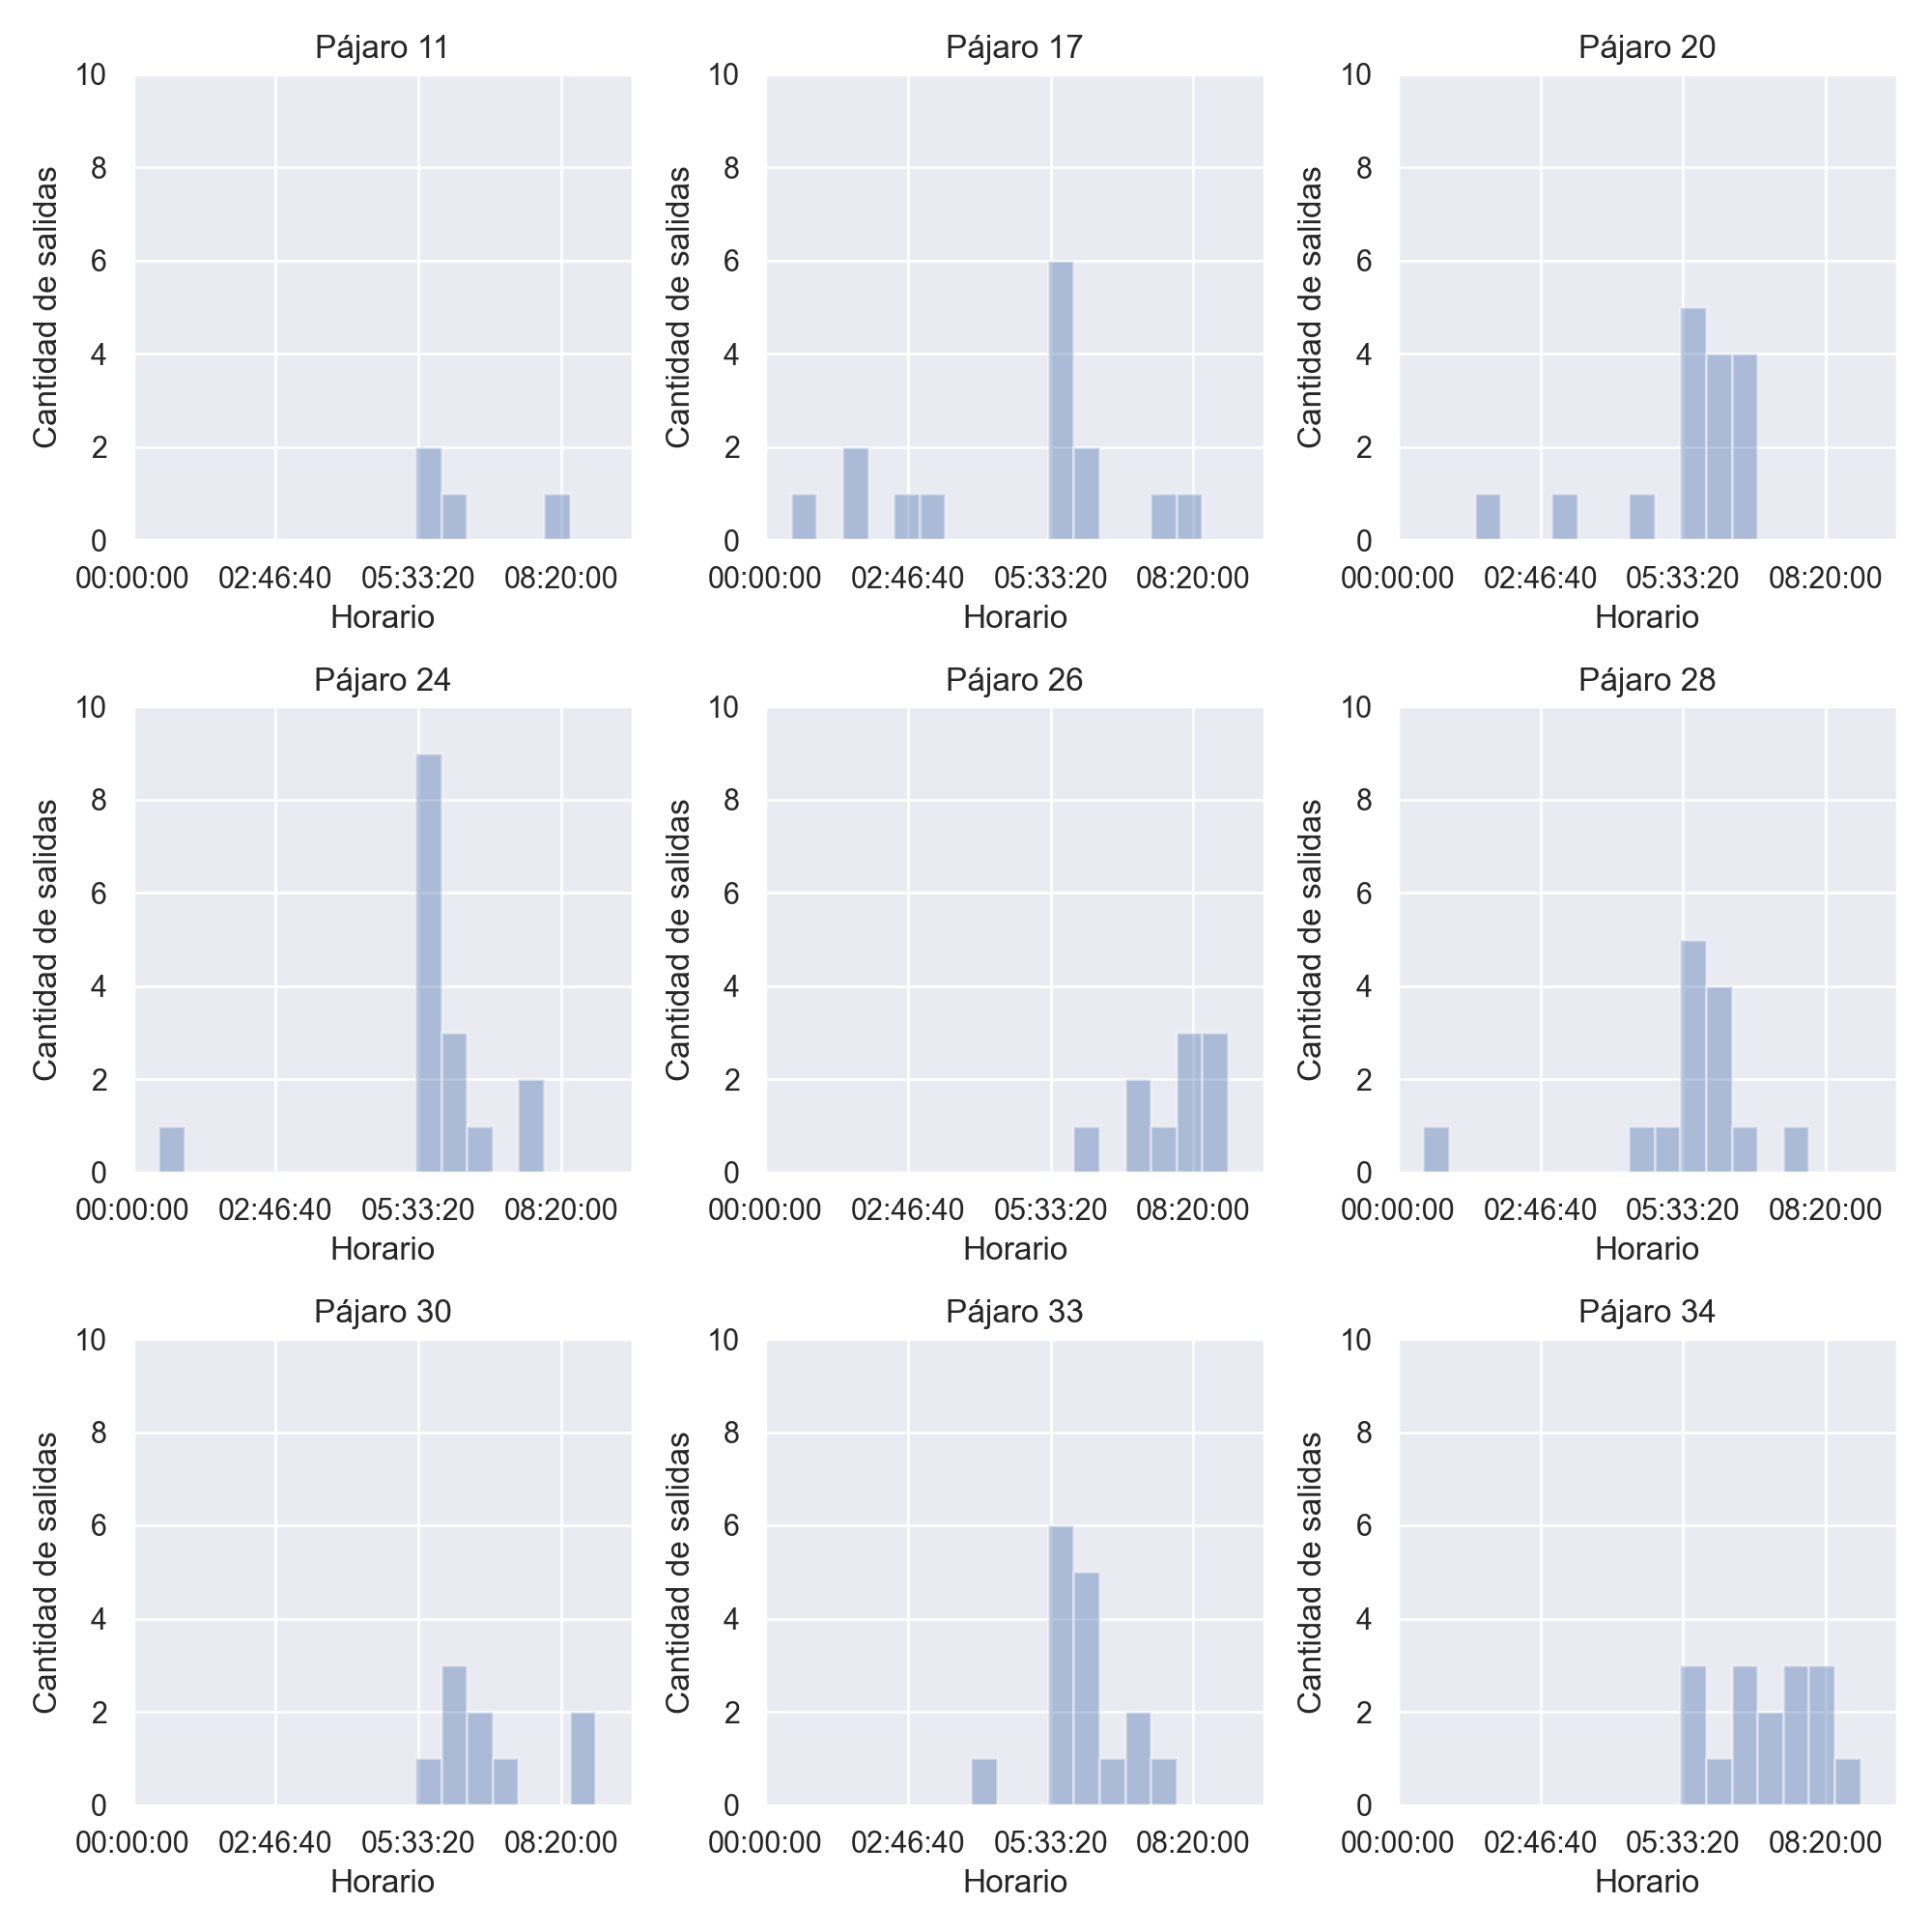

In [446]:
fig, axs = plt.subplots(3,3, figsize=(10,10))

fig.tight_layout()
i=0
for female in FEMALES:
    
    female_times_pd = pd.DataFrame(
        birds_exit_time_pd.reset_index().query('tag_id == {}'.format(female))["0"].str.split(' ').str[1].apply(get_secondos_of_day)
        #birds_exit_time_pd.reset_index().query('tag_id == {}'.format(female))["0"].apply(get_secondos_of_day)
    ).reset_index(drop=True)

    female_times_pd.columns = ['hour']
    female_times_pd['one'] = 1
    
    if len(female_times_pd[female_times_pd.hour.notna()]) == 0:
        print('No data for bird {}'.format(female))
        continue

    bins = [t*60*30 for t in range(19)]
    ax = axs.flatten()[i]
    sn.distplot(female_times_pd[female_times_pd.hour.notna()].hour, bins=bins, kde=False,ax=ax)
    ax.set_ylim((0,10))
    ax.set_xlim((0,35000))
    ax.set_xticklabels([get_hour_from_seq_time(tick) for tick in ax.get_xticks().astype(int)])
    ax.set_ylabel('Cantidad de salidas')
    ax.set_xlabel('Horario')
    ax.set_title(f'Pájaro {female}')
    i +=1



plt.tight_layout()
plt.savefig('Histograma-salida-hembras.png')